In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
from collections import Counter
from data_science_toolkit.data_visualization import get_fig_ax, visualize_class_distribution, top_n_tokens_plot_from_counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize 
# Stealing stuff... http://brandonrose.org/clustering
from nltk.stem.snowball import SnowballStemmer
import nltk, re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora, models, similarities 
from data_science_toolkit.association_rules import apriori_with_df
from data_science_toolkit.data_visualization import generate_histogram

In [2]:
output_col = 'above_monthly_avg'
# file_name = 'trump_tweets_sp500.csv'
file_name = 'elonmusk_twint_preprocessed.csv'

In [3]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [4]:
stop_words = set(stopwords.words('english')).union({'', 'would'})
# , '-', '&', '"', ':', '/'
stemmer = SnowballStemmer("english")

In [5]:
stock_tweet = pd.read_csv('./stocks/{}'.format(file_name))
stock_tweet['created_at']= pd.to_datetime(stock_tweet['created_at']) 

In [6]:
stock_tweet.head(2)

,text,retweet_count,retweet,num_videos,created_at,preprocessed_text,created_hour,dow,num_links,num_words,num_photos,above_monthly_avg,percent_caps,num_hashtags,num_mentions
0,"Please ignore prior tweets, as that was someone pretending to be me :) This is actually me.",122,False,0,2010-06-04 14:31:57,"please ignore prior tweets , as that was someone pretending to be me : ) this is actually me .",14,4,0,16,0,0,0.0,0,0
1,"Went to Iceland on Sat to ride bumper cars on ice! No, not the country, Vlad's rink in Van Nuys. Awesome family fun :) pic.twitter.com/rBQXJ9IT",17,False,0,2011-12-01 04:55:11,"went to iceland on sat to ride bumper cars on ice ! no , not the country , vlad 's rink in van nuys . awesome family fun : ) twitpicture",4,3,0,25,1,0,0.0,0,0


In [7]:
since_election = stock_tweet[stock_tweet["created_at"] > datetime(2016, 11, 8)]

In [8]:
prep_all_tweets = stock_tweet["preprocessed_text"].tolist()
prep_tweets_since_election = since_election["preprocessed_text"].tolist()

In [9]:
prep_tweets_since_election

['love you too ! msciurl ...',
 'we could enable that , although the cameras use grey , grey , grey , red detection , so it would look a little greyish red : )',
 "wow , thanks . we wo n't let you down .",
 'looks like the model s p100d easter egg will allow it to do 0 to 60 mph in 2.4 sec and a 10.6 sec 1/4 mile via software update next month',
 'model x numbers should also improve by 0.1 sec on 0 to 60 and 1/4 mile',
 'all p100d vehicles produced to date , as well as new . this is purely a software optimization .',
 'sounds right',
 'vote tally shows ~85 % of unaffiliated shareholders in favor of the tesla/solarcity merger ! thanks for believing .',
 'big mobile app update coming with 8.1 next month',
 "consequences of population implosion greatly underestimated . upside down demographic pyramid ca n't support social services .",
 'tesla self-driving ai with the benny hill option package msciurl ...',
 '-2',
 'yes',
 'that and paint it black will both be uploaded for free as easter (

# 1.0 Class Distribution

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


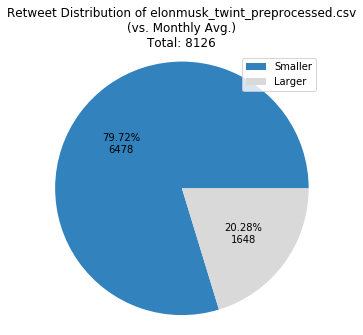

In [10]:
fig, ax = get_fig_ax(1, 1, 5, 5)
ax = visualize_class_distribution(stock_tweet[output_col], 
                                  given_title="Retweet Distribution of {}\n(vs. Monthly Avg.)".format(file_name), 
                                  given_label_titles={1: "Larger", 0:"Smaller"}, axes=ax, row_idx=0, col_idx=0)

## 1.1 Class Distribution since Election

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


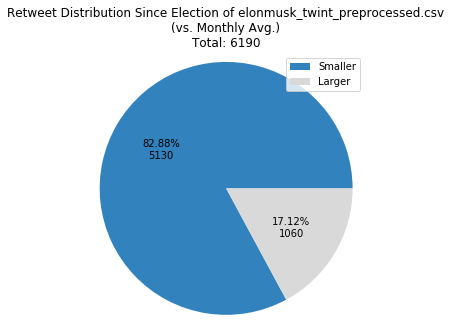

In [11]:
fig, ax = get_fig_ax(1, 1, 5, 5)
ax = visualize_class_distribution(since_election[output_col], 
                                  given_title="Retweet Distribution Since Election of {}\n(vs. Monthly Avg.)".format(file_name), 
                                  given_label_titles={1: "Larger", 0:"Smaller"}, axes=ax, row_idx=0, col_idx=0)

# 2.0 Most Common Words

In [12]:
def filtered_word_array(tweet, words_to_ignore={}):
    return [x for x in tweet.split(' ') if x not in stop_words.union(words_to_ignore) and re.search('[a-zA-Z]', x)]

In [13]:
stock_tweet.iloc[3500]

text                 😉                  
retweet_count        121                
retweet              False              
num_videos           0                  
created_at           2018-04-27 21:32:14
preprocessed_text    winkingface        
created_hour         21                 
dow                  4                  
num_links            0                  
num_words            1                  
num_photos           0                  
above_monthly_avg    0                  
percent_caps         0                  
num_hashtags         0                  
num_mentions         0                  
Name: 3500, dtype: object

In [14]:
prep_all_tweets[3500]

'winkingface'

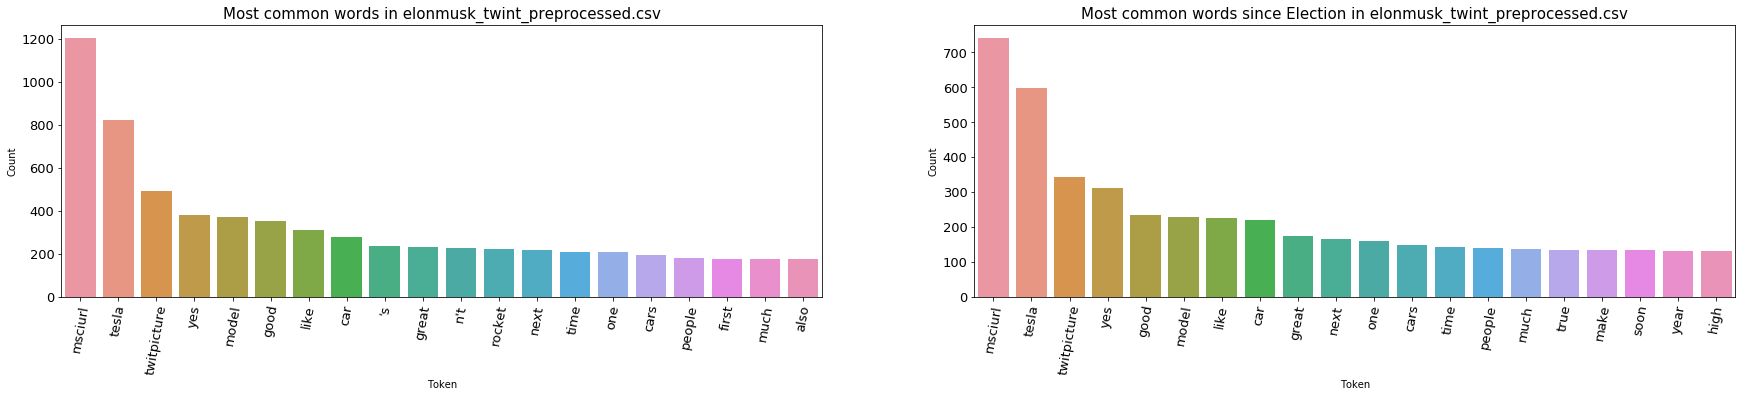

In [15]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(Counter([x for x in filtered_word_array(' '.join(prep_all_tweets))]), 
                                    20, ax, 0, 0, "Most common words in {}".format(file_name))
ax = top_n_tokens_plot_from_counter(Counter([x for x in filtered_word_array(' '.join(prep_tweets_since_election))]), 
                                    20, ax, 0, 1, "Most common words since Election in {}".format(file_name))

## 2.1 Most Common Words (Larger vs Smaller than monthly average)

In [16]:
above_avg = stock_tweet[stock_tweet[output_col] == 1]
above_avg_since_election = since_election[since_election[output_col] == 1]
below_avg = stock_tweet[stock_tweet[output_col] == 0]
below_avg_since_election = since_election[since_election[output_col] == 0]

In [17]:
def get_count_no_sw(df):
    return Counter(filtered_word_array(' '.join(df['preprocessed_text'].tolist())))

In [18]:
above_not_below = get_count_no_sw(above_avg) - get_count_no_sw(below_avg)
above_not_below_since_election = get_count_no_sw(above_avg_since_election) - get_count_no_sw(below_avg_since_election)
below_not_above = get_count_no_sw(below_avg) - get_count_no_sw(above_avg)
below_not_above_since_election = get_count_no_sw(below_avg_since_election) - get_count_no_sw(above_avg_since_election)

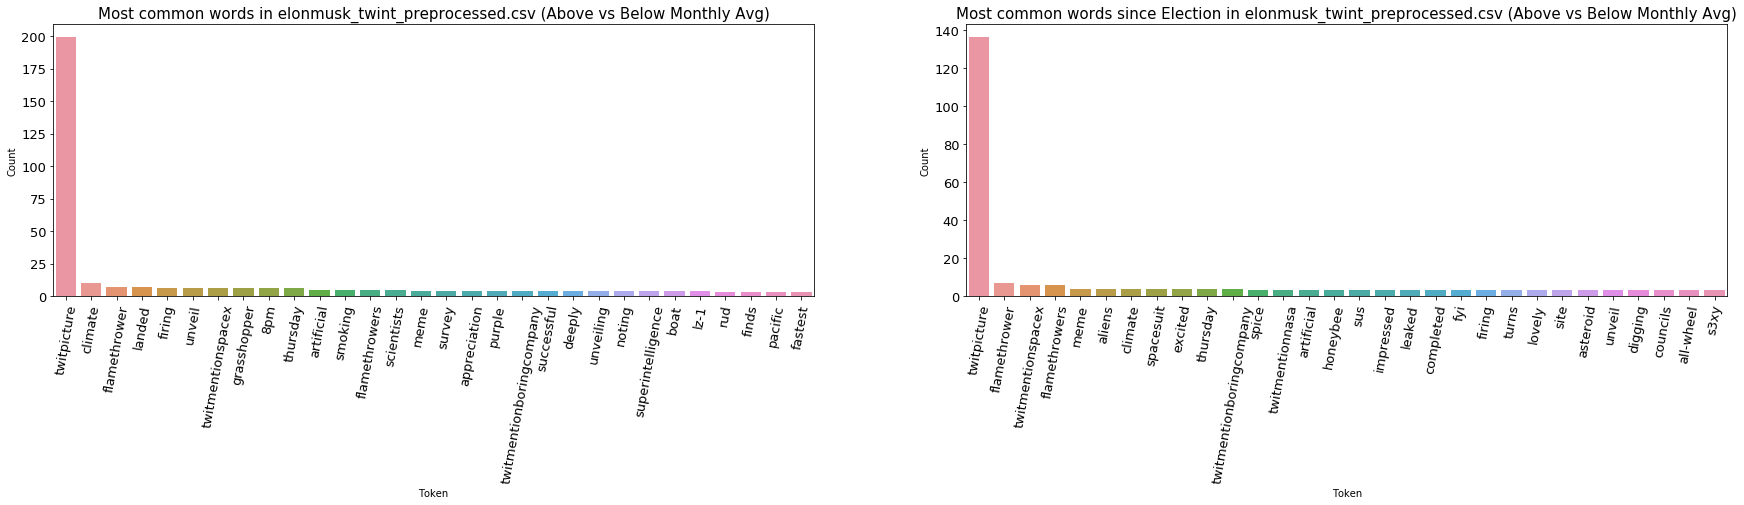

In [19]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(above_not_below, 30, ax, 0, 0, 
                                    "Most common words in {} (Above vs Below Monthly Avg)".format(file_name))
ax = top_n_tokens_plot_from_counter(above_not_below_since_election, 30, ax, 0, 1, 
                                    "Most common words since Election in {} (Above vs Below Monthly Avg)".format(file_name))

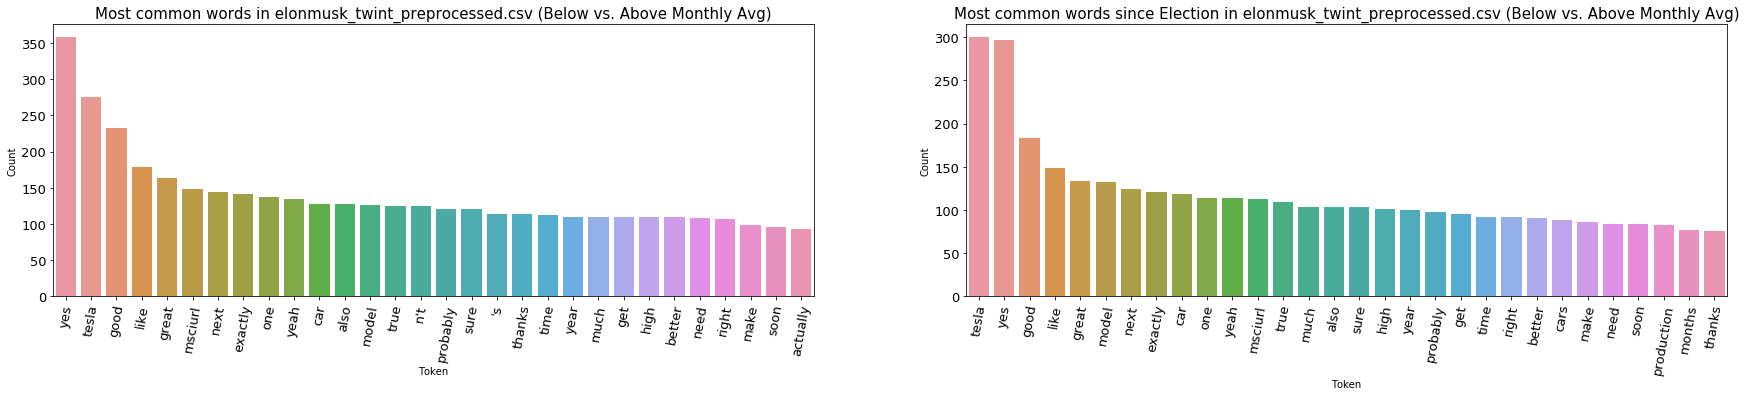

In [20]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(below_not_above, 30, ax, 0, 0, 
                                    "Most common words in {} (Below vs. Above Monthly Avg)".format(file_name))
ax = top_n_tokens_plot_from_counter(below_not_above_since_election, 30, ax, 0, 1, 
                                    "Most common words since Election in {} (Below vs. Above Monthly Avg)".format(file_name))

# K-Means Clustering for Common Topics

Summarize this but don't need to say much else

Ran out of memory trying to do this for all Trump tweets - I'm only going to do it for tweets since the election.  
Elbow method: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

# 3.0 Apriori - Featuresets
- Due to the small number of tweets, etc, we need to use a relatively low support of 0.02 before starting to look for rules

In [21]:
def prep_fn(text):
    text = text.split(" ")
    final = []
    for word in text:
        if re.search('[a-zA-Z]', word) and word not in stop_words:
            final.append(word)
    return final

In [22]:
frequent_itemsets = apriori_with_df(prep_tweets_since_election, prep_fn, min_support=0.02, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.021002,(also)
1,0.032633,(car)
2,0.021971,(cars)
3,0.037480,(good)
4,0.026817,(great)
5,0.020355,(high)
6,0.034410,(like)
7,0.020840,(make)
8,0.033118,(model)
9,0.116801,(msciurl)


## Using these frequent itemsets, we can come up with association rules:

In [23]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


## We can use these itemsets as inputs to our SVM

# WILL NEED TO MOVE THIS INTO THE CROSS VALIDATION PIPELINE!!!

In [24]:
above_avg_apr = apriori_with_df(since_election[since_election[output_col] == 1]['preprocessed_text'].tolist(), prep_fn).values.tolist()
above_avg_apr_dict = {x[1]: x[0] for x in above_avg_apr if len(x[1]) > 1}
above_avg_apr_set = set([x[1] for x in above_avg_apr])

In [25]:
below_avg_apr = apriori_with_df(since_election[since_election[output_col] == 0]['preprocessed_text'], prep_fn).values.tolist()
below_avg_apr_dict = {x[1]: x[0] for x in below_avg_apr if len(x[1]) > 1}
below_avg_apr_set = set([x[1] for x in below_avg_apr])

In [26]:
below_avg_apr_dict

{}

In [27]:
above_avg_apr_diff = Counter(above_avg_apr_dict) - Counter(below_avg_apr_dict)

In [28]:
below_avg_apr_diff = Counter(below_avg_apr_dict) - Counter(above_avg_apr_dict)

In [29]:
below_avg_apr_diff.items()

dict_items([])

In [30]:
above_avg_apr_feats = sorted([x for x in above_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)
below_avg_apr_feats = sorted([x for x in below_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)

In [31]:
above_avg_apr_feats

[(frozenset({'msciurl', 'tesla'}), 0.04339622641509434)]

In [32]:
# feat = above_avg_apr_feats[0]

In [33]:
def contains_feature(tweets, feat):
    contains_feat_list = []
    for tweet in tweets:
        curr_set = [1 if word in set(tweet) else 0 for word in feat]
#         print(feat, curr_set)
#         print(ting)
        contains_feat_list.append(min(curr_set))
    return contains_feat_list

In [34]:
tweets = list(map(lambda x: x.split(" "), prep_tweets_since_election))

In [35]:
for feat in above_avg_apr_feats:
    col_name = "above_avg_apr_{}".format('_'.join(feat[0]))
    since_election[col_name] = contains_feature(tweets, feat[0])
    since_election[col_name] = since_election[col_name].astype('category')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [36]:
for feat in below_avg_apr_feats:
    col_name = "below_avg_apr_{}".format('_'.join(feat[0]))
    since_election[col_name] = contains_feature(tweets, feat[0])
    since_election[col_name] = since_election[col_name].astype('category')

In [37]:
since_election.columns

Index(['text', 'retweet_count', 'retweet', 'num_videos', 'created_at',
       'preprocessed_text', 'created_hour', 'dow', 'num_links', 'num_words',
       'num_photos', 'above_monthly_avg', 'percent_caps', 'num_hashtags',
       'num_mentions', 'above_avg_apr_tesla_msciurl'],
      dtype='object')

## 3.3 LDA for Topic Clustering - SKIPPING FOR NOW, SINCE IT'S NOT TECHNICALLY PART OF THE REPORT

This section focuses on using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure within the top 100 film synopses. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. There is quite a good high-level overview of probabilistic topic models by one of the big names in the field, David Blei, available in the Communications of the ACM here. Incidentally, Blei was one of the authors of the seminal paper on LDA.
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

HAD TO ADD THE WORD "GREAT" TO THE STOPWORD LIST BECAUSE IT WAS IN LITERALLY EVERY CLUSTER...

## NOTE THAT EVERY CLUSTERING THING WILL LIKELY HAVE SLIGHTLY DIFFERENT PREPROCESSING PARAMS!!!

In [79]:
# Remove proper nouns (in this case get rid of all mentions)
# TRUMP ==============================================================================================================
# since_election['preprocessed_no_mentions'] = since_election['preprocessed_text'].apply(lambda tweet: ' '.join([w for w in tweet.split(' ') 
#                                                                                                                if w not in stop_words.union({'msciurl', 'twitpicture', 'great'}) 
#                                                                                                                and re.search('[a-zA-Z]', w)]))

# ELON MUSK ===========================================================================================================
# Remove proper nouns (in this case get rid of all mentions)
since_election['preprocessed_no_mentions'] = since_election['preprocessed_text'].apply(lambda tweet: ' '.join([w for w in tweet.split(' ') 
                                                                                                               if w not in stop_words.union({'msciurl', 'twitpicture', "'s'"}) 
                                                                                                               and re.search('[a-zA-Z]', w)]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [80]:
texts = [[ting for ting in x.split(" ") if ting != ''] for x in since_election['preprocessed_no_mentions'].tolist()]
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.3)
# 0.21

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [73]:
coherence_scores = []
for i in range(2, 50, 2):
    lda = models.LdaMulticore(corpus, num_topics=i, 
                                id2word=dictionary, iterations=500)
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

In [74]:
# coherence_scores

Text(0.5, 0, 'Num Topics')

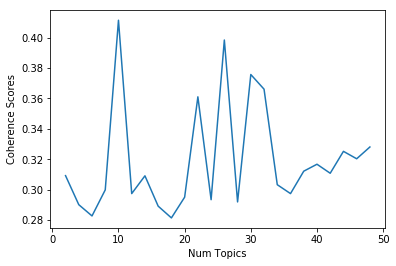

In [75]:
plt.plot([x for x in range(2, 50, 2)], coherence_scores)
plt.ylabel("Coherence Scores")
plt.xlabel("Num Topics")

In [81]:
lda_num_topics = 12

In [82]:
lda = models.LdaMulticore(corpus, num_topics=lda_num_topics, iterations=500,
                                id2word=dictionary)

In [83]:
lda.show_topics(num_topics=lda_num_topics)

[(0,
  '0.011*"tesla" + 0.008*"exactly" + 0.007*"car" + 0.006*"model" + 0.004*"soon" + 0.004*"good" + 0.004*"maybe" + 0.004*"make" + 0.004*"people" + 0.004*"month"'),
 (1,
  '0.030*"yes" + 0.009*"next" + 0.008*"good" + 0.007*"soon" + 0.006*"coming" + 0.006*"point" + 0.006*"yeah" + 0.006*"ok" + 0.005*"model" + 0.005*"high"'),
 (2,
  '0.014*"tesla" + 0.005*"people" + 0.005*"high" + 0.005*"car" + 0.005*"good" + 0.004*"cars" + 0.004*"\'s" + 0.004*"need" + 0.004*"thanks" + 0.004*"like"'),
 (3,
  '0.007*"tesla" + 0.007*"sure" + 0.006*"great" + 0.005*"really" + 0.005*"make" + 0.005*"almost" + 0.004*"cars" + 0.004*"many" + 0.004*"good" + 0.004*"time"'),
 (4,
  '0.007*"tesla" + 0.006*"model" + 0.005*"good" + 0.004*"time" + 0.004*"rocket" + 0.004*"launch" + 0.004*"need" + 0.004*"get" + 0.004*"falcon" + 0.004*"much"'),
 (5,
  '0.015*"yes" + 0.006*"also" + 0.006*"mars" + 0.005*"tesla" + 0.004*"model" + 0.003*"year" + 0.003*"right" + 0.003*"real" + 0.003*"production" + 0.003*"next"'),
 (6,
  '0.014

- The area of circle represents the importance of each topic over the entire corpus
- The distance between the center of circles indicate the similarity between topics.
- Indices = sorted order by area
- Blue = overall term frequency
- Red = term freq within selected topic
- Lambda: trying to strike a balance between choosing general vs specific words (lambda=0 means super specific - exclusively popular for this topic)
- If some topics contain general words/feelings/sentiments

In [84]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [85]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)
df_dominant_topic['preprocessed_text'] = prep_tweets_since_election

In [86]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda.show_topics(num_topics=lda_num_topics, formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

# print(lda.show_topics(num_topics=lda_num_topics, formatted=False))

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(' '.join)
df_top3words.reset_index(level=0,inplace=True)
df_top3words

,topic_id,words
0,0,tesla exactly car
1,1,yes next good
2,2,tesla people high
3,3,tesla sure great
4,4,tesla model good
5,5,yes also mars
6,6,tesla true sure
7,7,tesla soon high
8,8,tesla car one
9,9,tesla us team


In [49]:
df = None
sample_size=5
for i in range(lda_num_topics):
    curr_cluster = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == i].sort_values(by='Topic_Perc_Contrib', ascending=False)
    if df is None:
        df = curr_cluster.head(sample_size)#.sample(n=min(sample_size, len(curr_cluster.index)-1))
    else:
        df = df.append(curr_cluster.head(sample_size))#curr_cluster.sample(n=min(sample_size, len(curr_cluster.index)-1)))
    df = df.append(pd.Series(), ignore_index=True)
df[["preprocessed_text", "Dominant_Topic", 'Topic_Perc_Contrib']]

,preprocessed_text,Dominant_Topic,Topic_Perc_Contrib
0,"read das kapital when i was 14 , incl cross-checking english translation of original german . adam smith ftw obv . ironically , future automation will naturally lead to greater equality of consumption . monopolies are true enemy of people . competing to serve is good .",0.0,0.9684
1,"clayton is wrong . new tech is always expensive . tech disruption occurs at *high end* , eg computers & cell phones . it takes many design iterations & vast economies of scale to achieve mass market affordability . twitpicture",0.0,0.9672
2,"singapore has enough land area to generate most of its electricity from the sun . solar energy is more than most people realize . 250mw per sq km at current commercial efficiency solar panels . no more need to import fossil fuels for electricity , which is a strategic vulnerability .",0.0,0.9672
3,"that ' s really decision about how good you think govt is at allocating capital . buffett , for example , is vastly better than any govt at allocating capital . consumption vs capital allocation extremely misunderstood . biggest missing piece in public understanding of what "" money "" is .",0.0,0.9660
4,vacuum nozzle engines are only used in ( near ) vacuum conditions . sea level engines need to gimbal rapidly & at high angle for landing . larger nozzle leaves less room to move & increases moment of inertia .,0.0,0.9647
5,NaN,NaN,NaN
6,"very much so . there are 2.5b cars & trucks on earth . even replacing 1 % of that fleet would require making 25m vehicles per year . tesla will make over 500k cars in next 12 months , but that ' s a mere 2 % of 25m or 0.02 % of global vehicle fleet . car industry slow - > demand > > supply .",1.0,0.9704
7,"about a year ago , i asked doug to manage both engineering & production . he agreed that tesla needed eng & prod better aligned , so we don ' t design cars that are crazy hard to build . right now , tho , better to divide & conquer , so i ' m back to sleeping at factory . car biz is hell ...",1.0,0.9704
8,"tesla goes bankrupt palo alto , california , april 1 , 2018 -- despite intense efforts to raise money , including a last-ditch mass sale of easter eggs , we are sad to report that tesla has gone completely and totally bankrupt . so bankrupt , you ca n't believe it .",1.0,0.9694
9,"more "" reveal "" bs . tesla is overseen by cal/osha , most stringent labor safety org in us , & they ' ve never found us to misrepresent . on other hand , ford , chrysler & gm ( uaw ) have repeatedly been found to fake safety numbers . strangely , that info is missing from reveal article ...",1.0,0.9694


# SAVE DATA (COMMENTED OUT)

In [50]:
# lda.save('44_clusters_removed_great_lda.model')
# df.to_csv('lda_44_clusters_removed_great.csv', index=False)

# LDA VISUALIZATION (COMMENTED OUT)

In [51]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
vis

# 4.0 Distributions

## 4.1.1 Time of Day (Up vs Down)

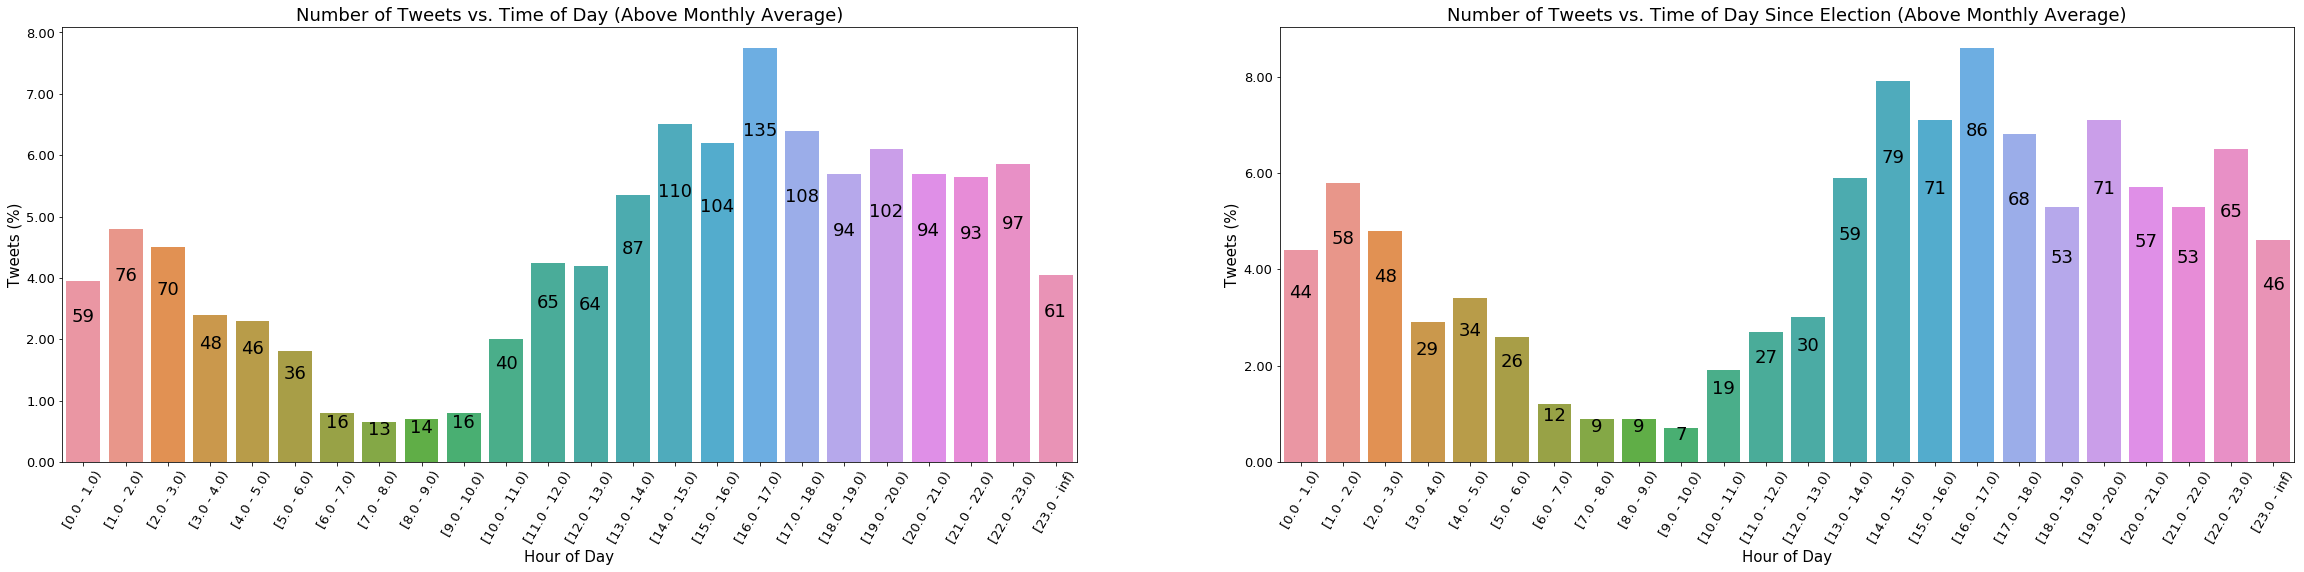

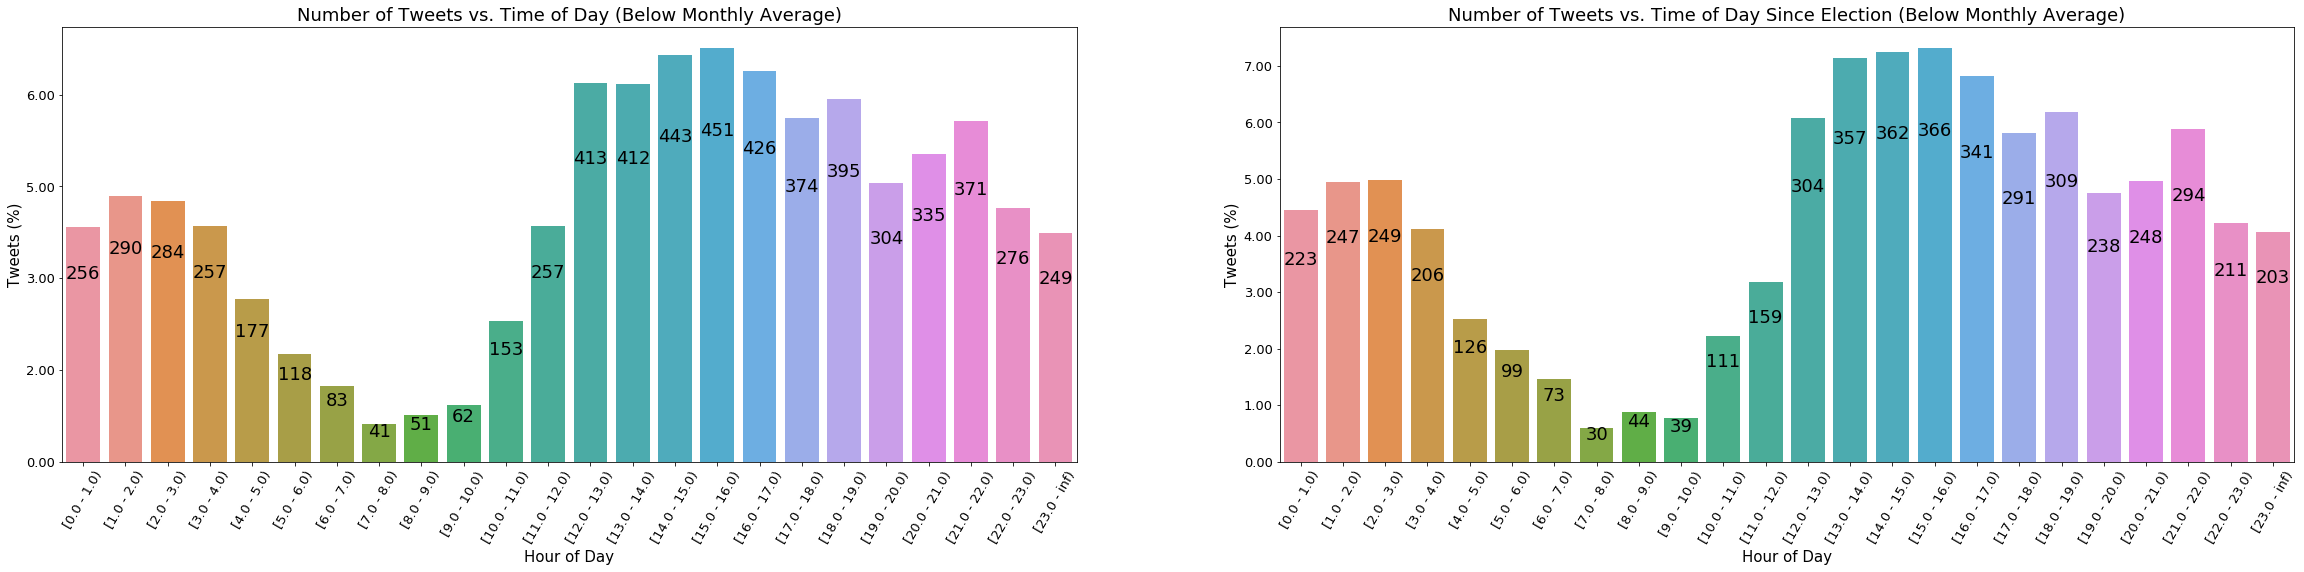

In [52]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["created_hour"], ax, 0, 0, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day (Above Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["created_hour"], ax, 0, 1, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day Since Election (Above Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["created_hour"], ax, 0, 0, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day (Below Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["created_hour"], ax, 0, 1, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day Since Election (Below Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)

## 4.2.1 Day of Week (Up vs Down)

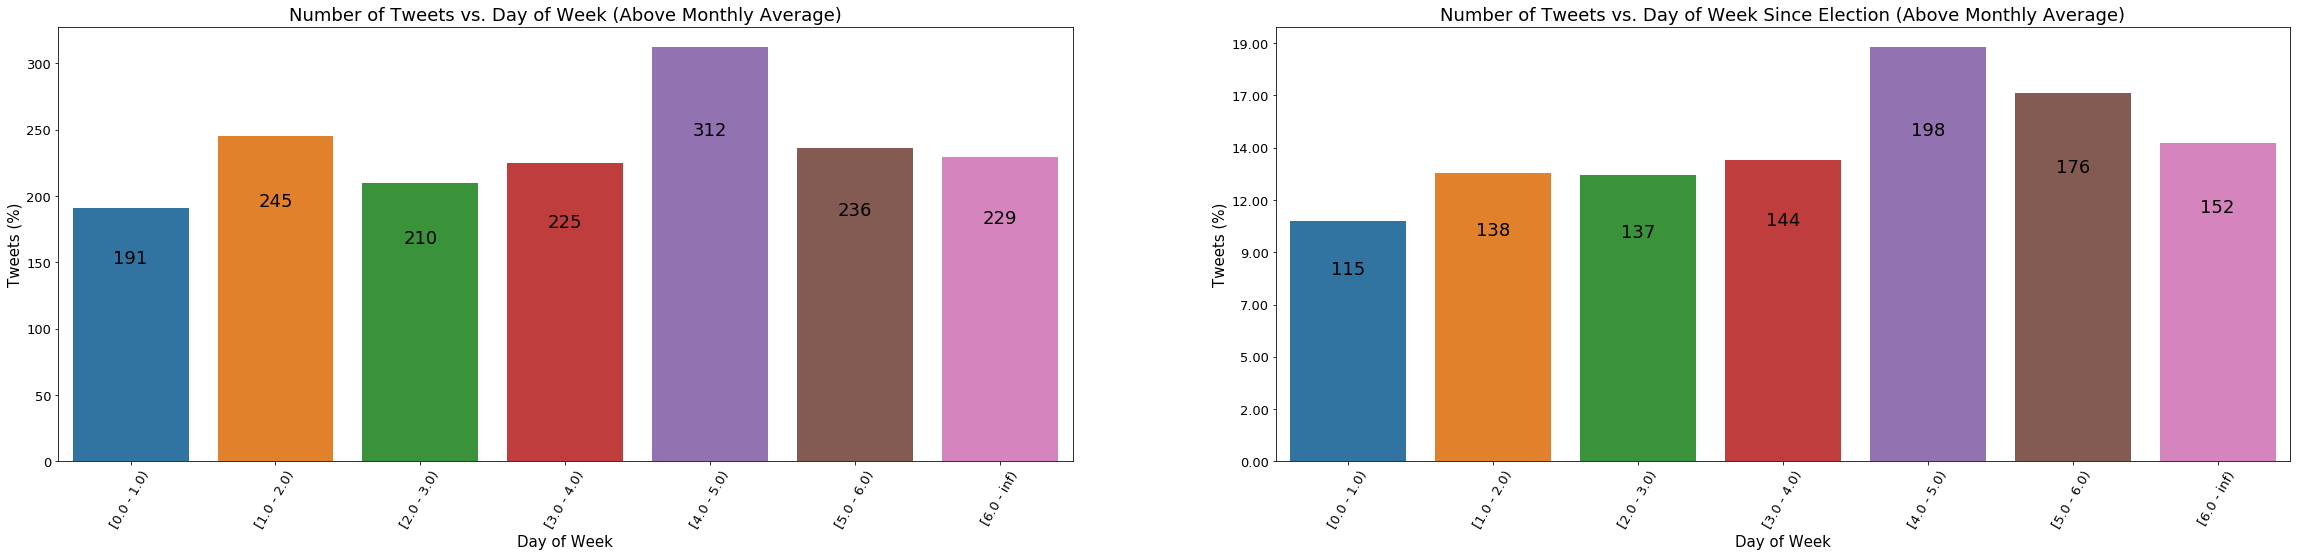

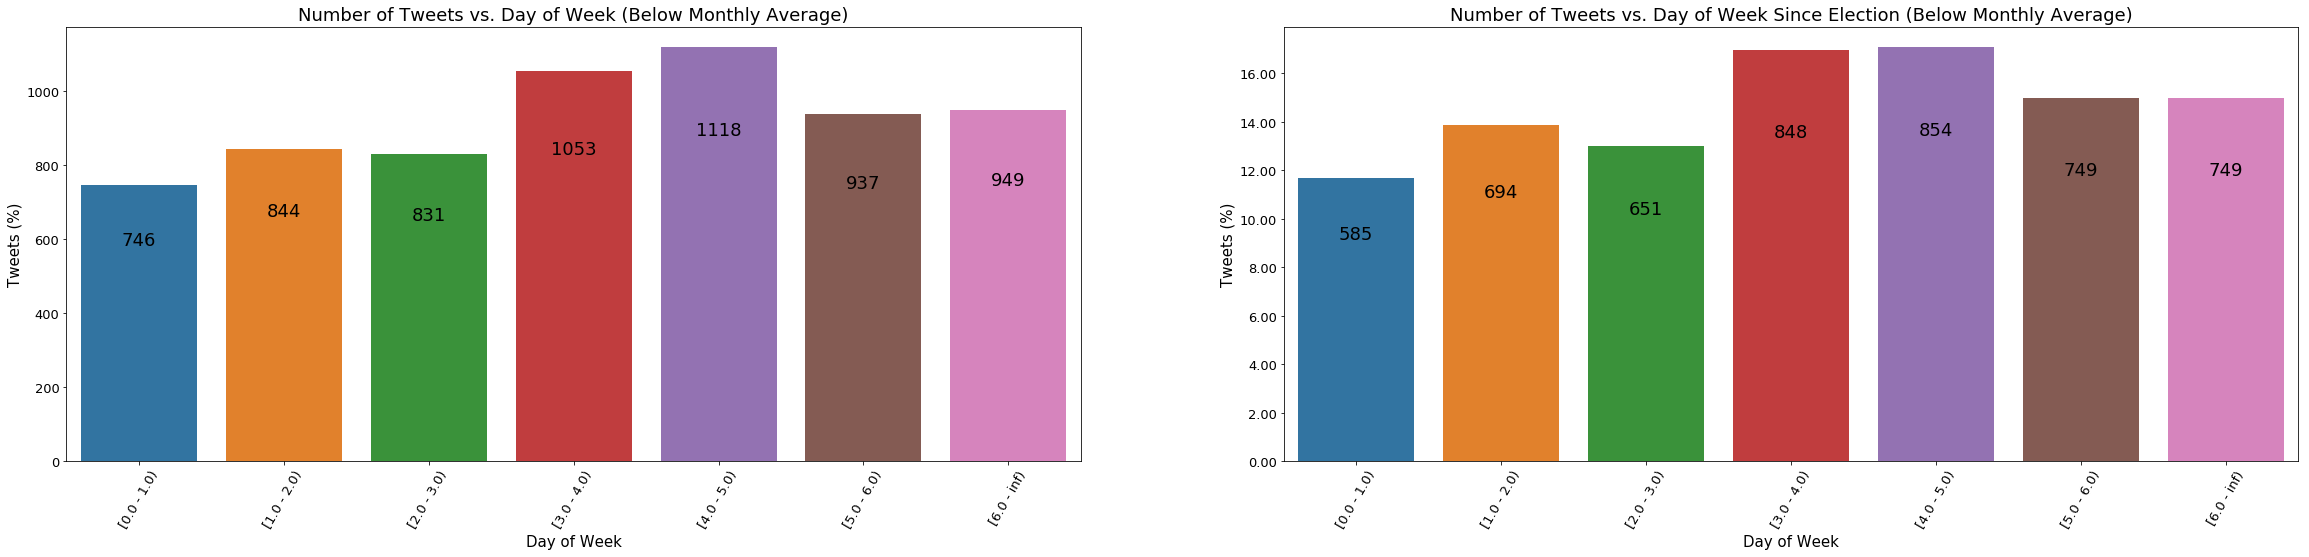

In [53]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["dow"], ax, 0, 0, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week (Above Monthly Average)", False, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["dow"], ax, 0, 1, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week Since Election (Above Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["dow"], ax, 0, 0, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week (Below Monthly Average)", False, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["dow"], ax, 0, 1, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week Since Election (Below Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)

## 4.3 Num Retweets over Time

In [54]:
from data_science_toolkit.file_ops import read_pkl
dt_avg = read_pkl("dt_avg_{}.pkl".format(file_name))

In [55]:
avg_retweets, dates = [], []
for year in dt_avg:
    for month in dt_avg[year]:
        avg_retweets.append(dt_avg[year][month])
        dates.append(datetime(year, month, 1))
dates, avg_retweets = list(zip(*sorted(list(zip(dates, avg_retweets)), key=lambda x: x[0])))

# Average Number of Retweets per Month
- The average number of retweets Trump gets per month varies significantly, and also jumped during the middle of the year (around when he got elected)
- This makes comparing to a monthly average more appropriate

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


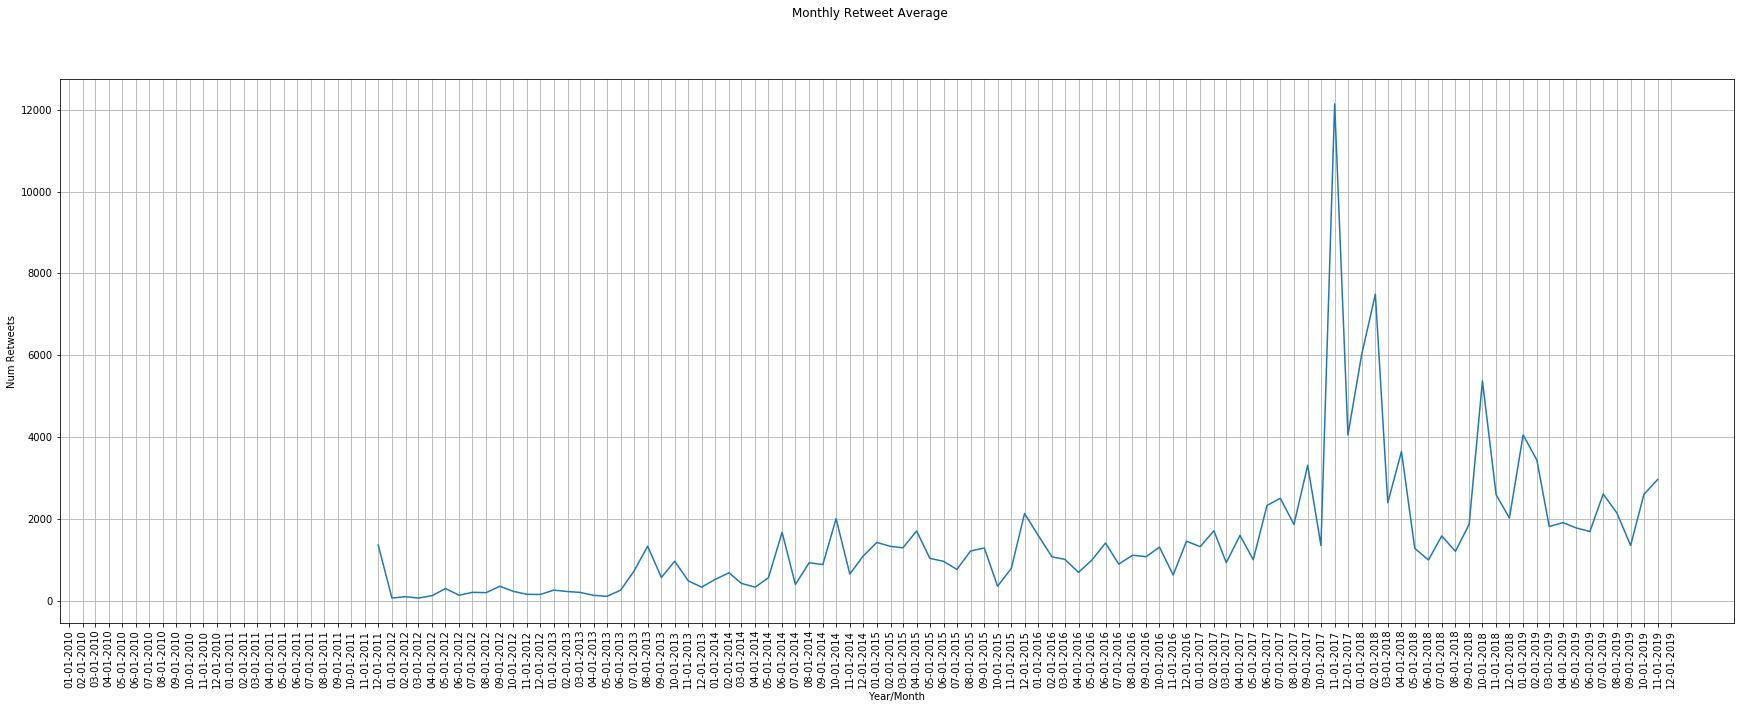

In [56]:
fig = plt.figure(figsize=(30, 10))
plt.plot(dates, avg_retweets)
fig.suptitle('Monthly Retweet Average')
plt.xlabel('Year/Month')
plt.ylabel('Num Retweets')
plt.xticks(dates, [x.strftime('%m-%d-%Y') for x in dates], rotation=90)
plt.grid(True)
plt.show()

## 5.1 Tweet Anatomy

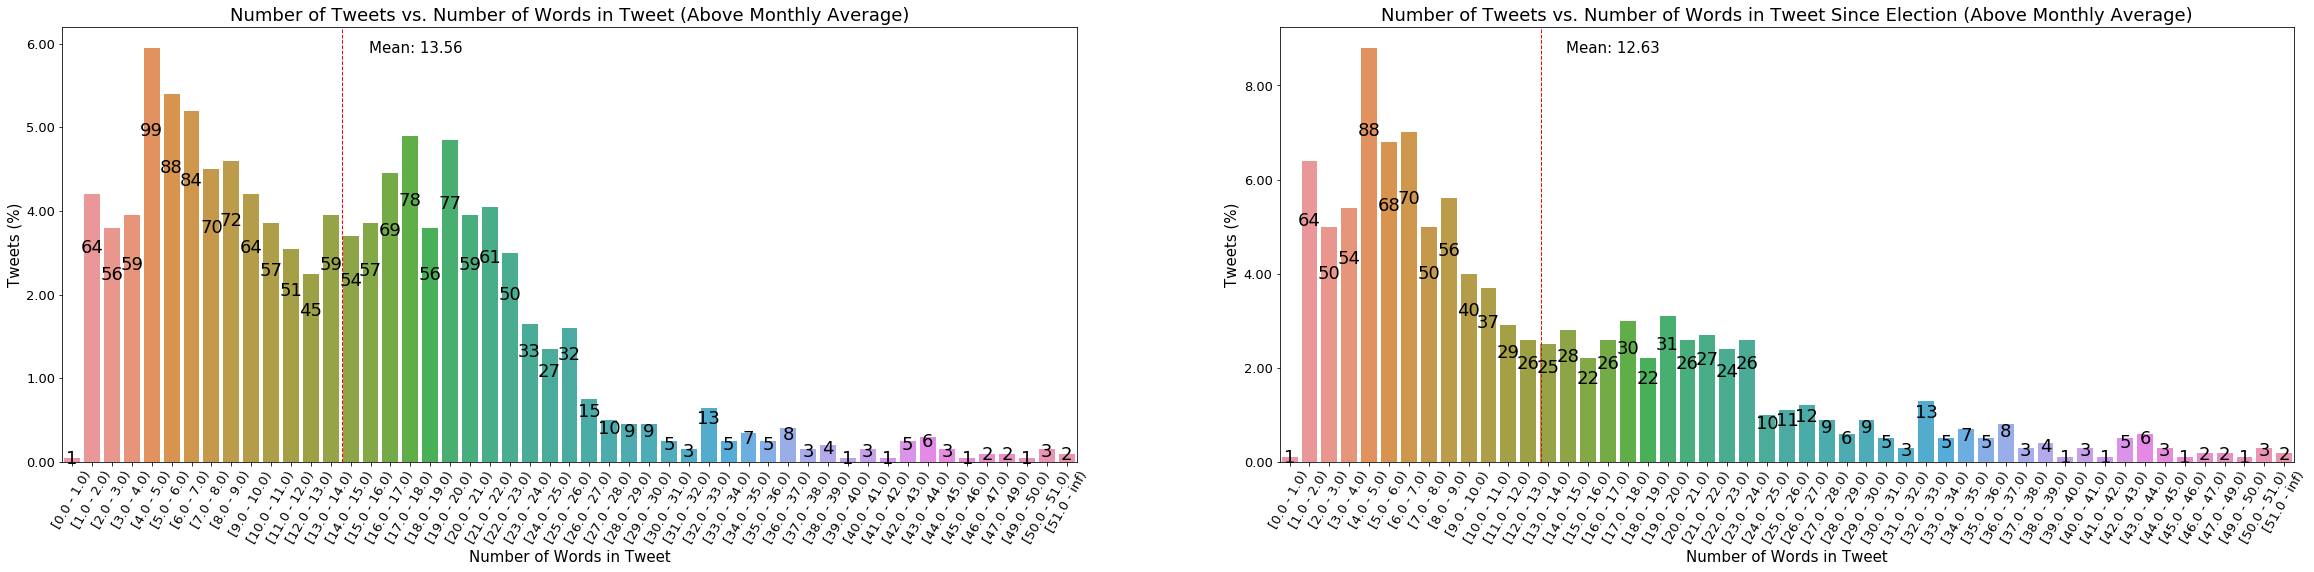

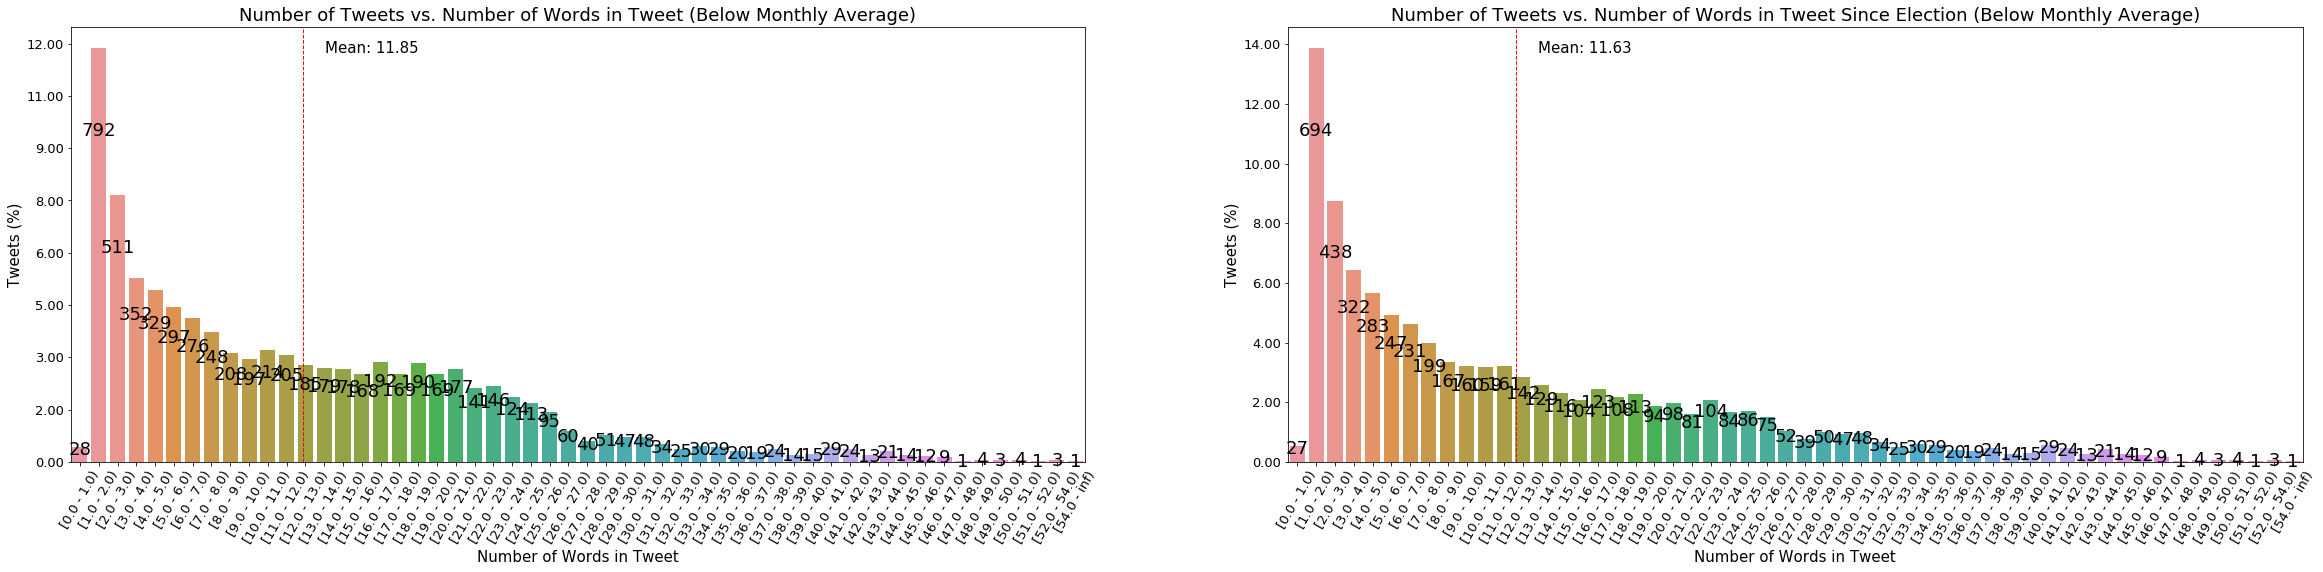

In [57]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_words"], ax, 0, 0, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_words"], ax, 0, 1, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_words"], ax, 0, 0, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_words"], ax, 0, 1, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [58]:
# since_election[since_election.num_words > 55]

In [59]:
set(stock_tweet[stock_tweet[output_col] == 0]['num_links'].tolist())

{0, 1}

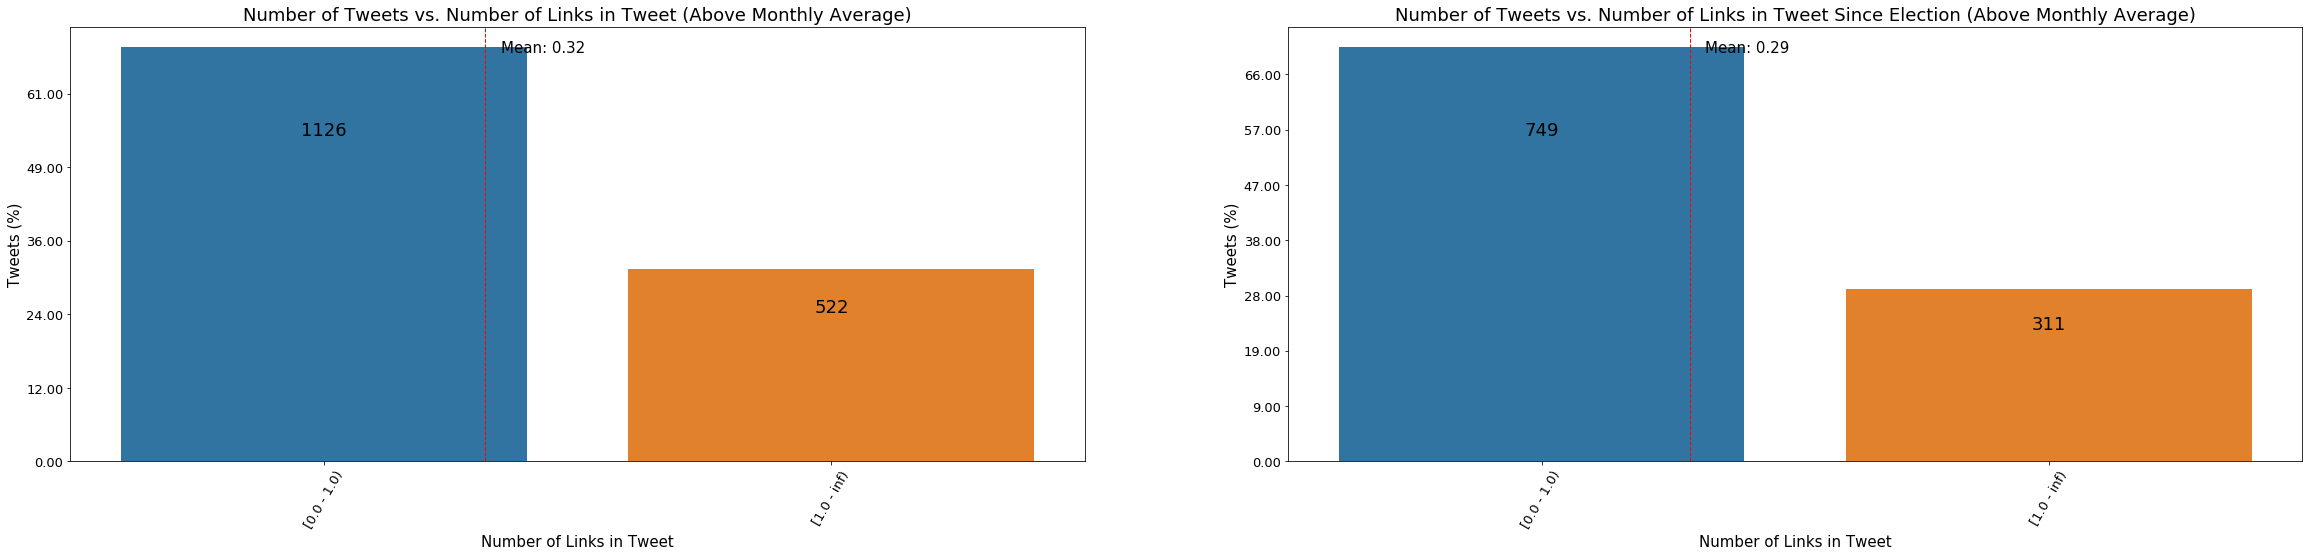

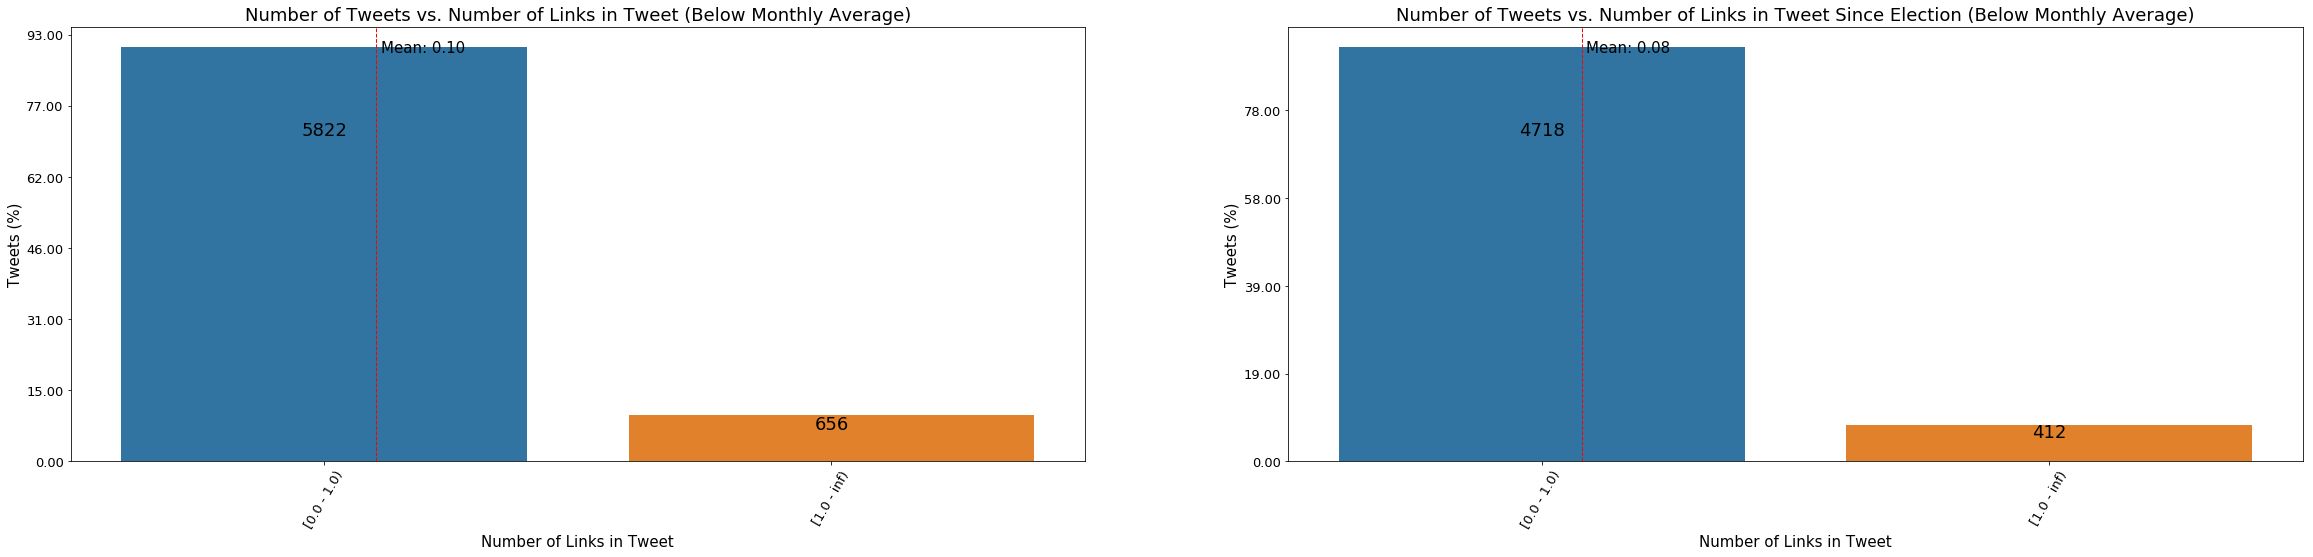

In [60]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_links"], ax, 0, 0, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_links"], ax, 0, 1, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_links"], ax, 0, 0, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_links"], ax, 0, 1, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

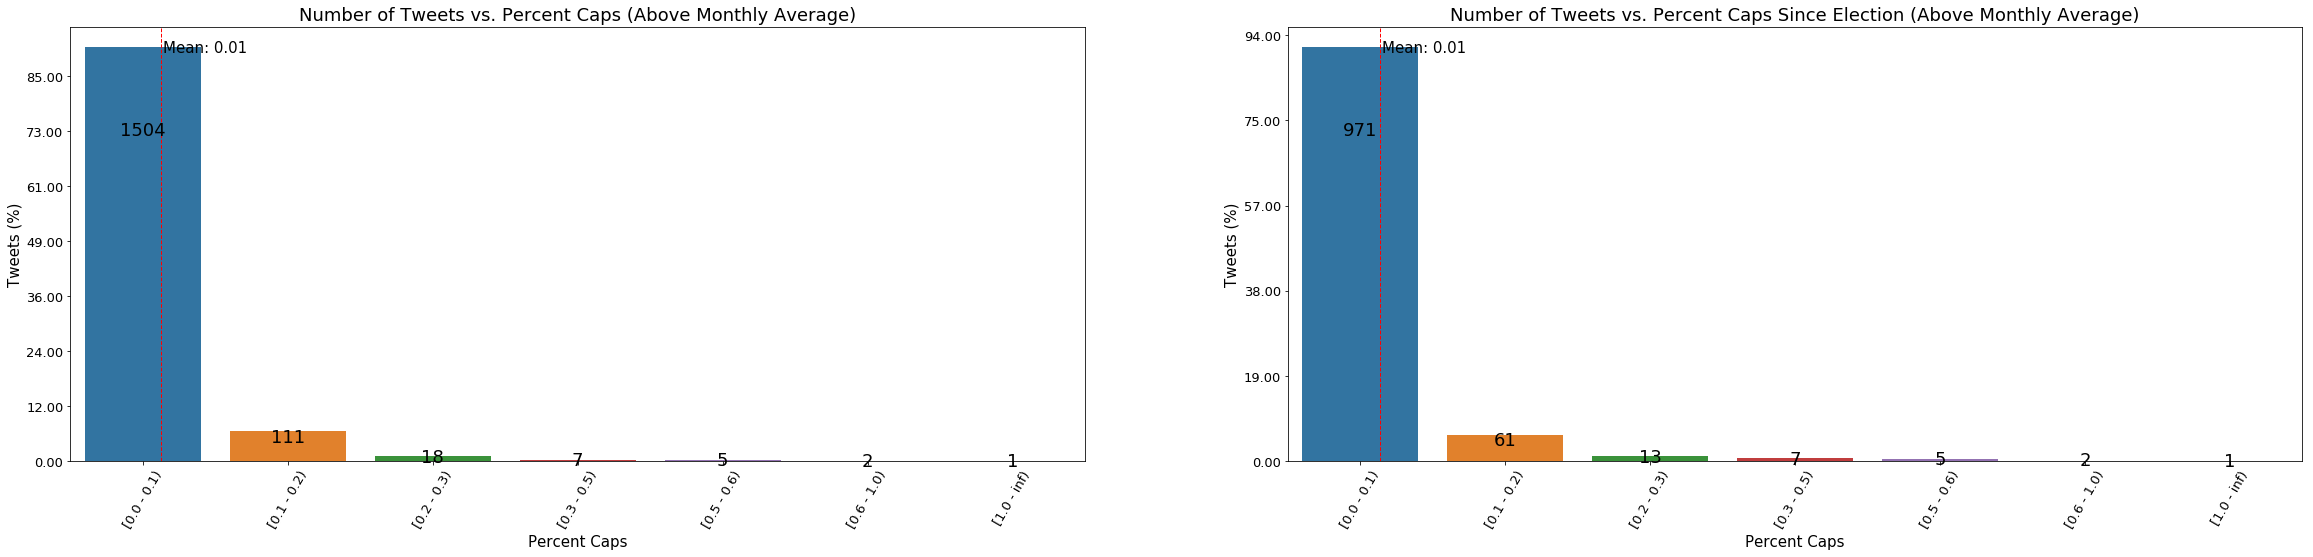

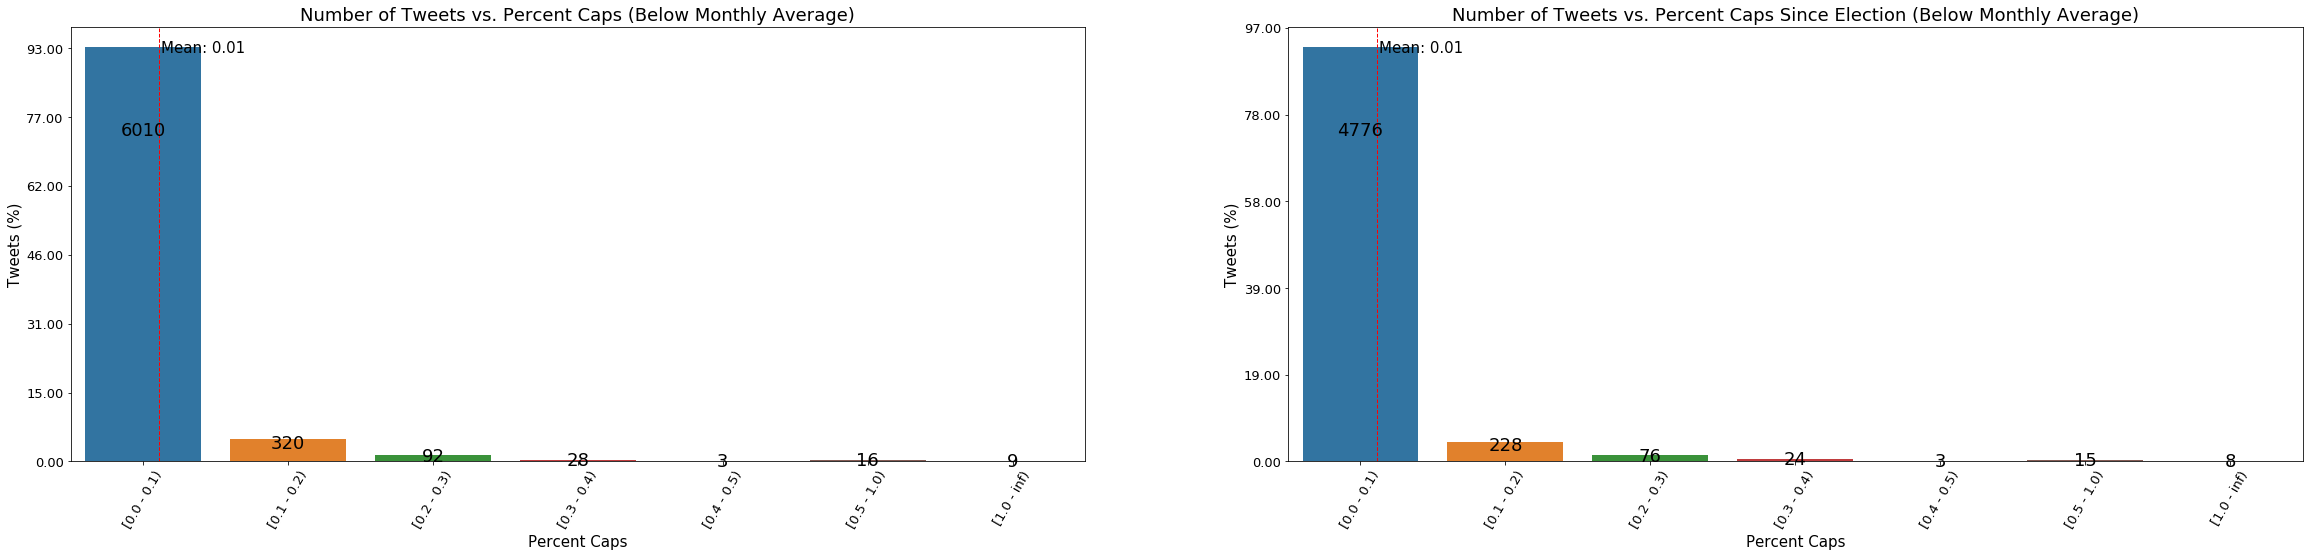

In [61]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["percent_caps"], ax, 0, 0, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["percent_caps"], ax, 0, 1, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["percent_caps"], ax, 0, 0, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["percent_caps"], ax, 0, 1, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

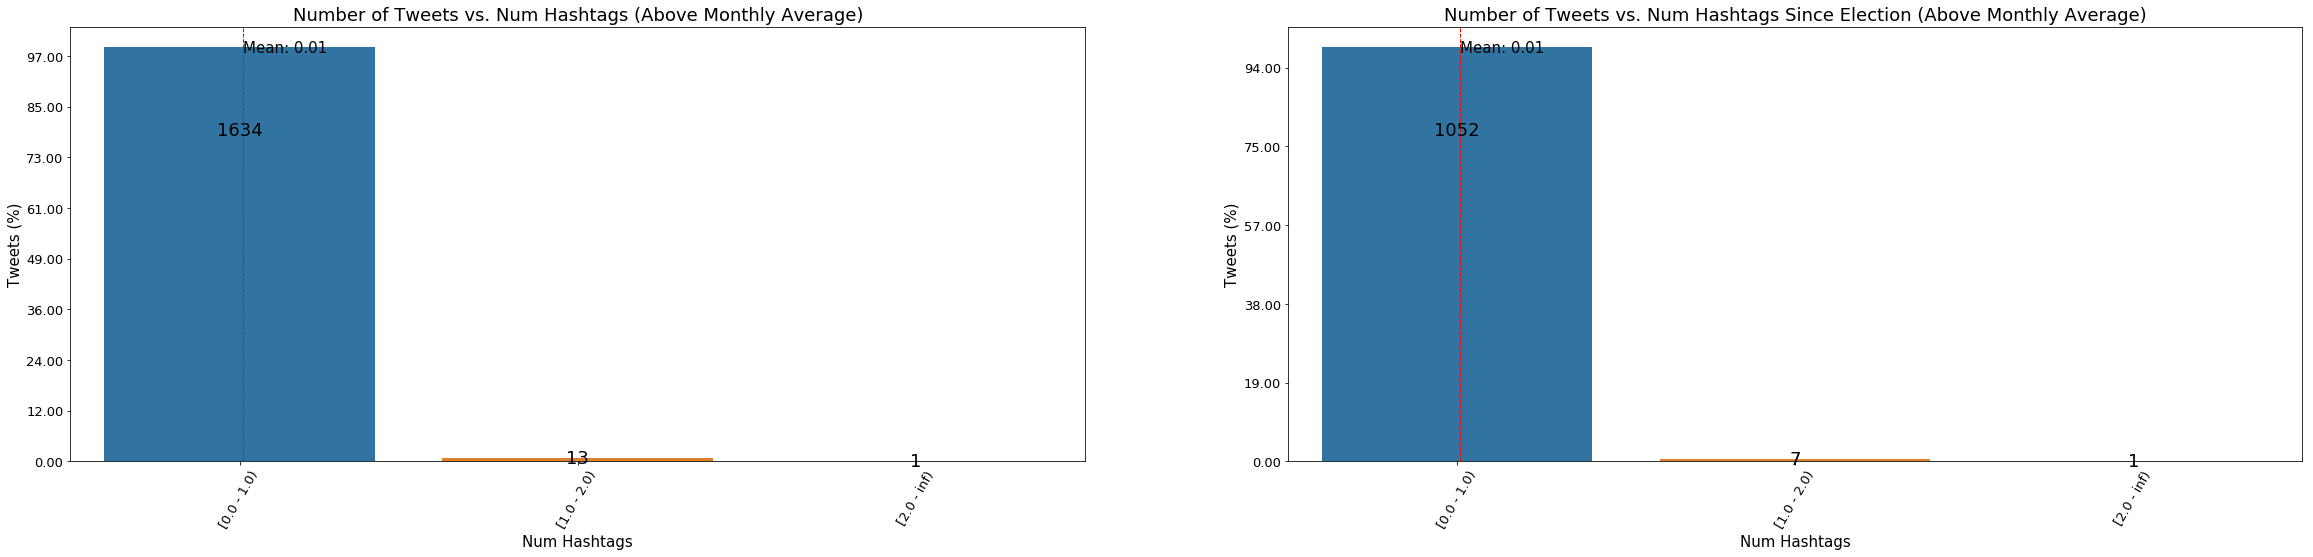

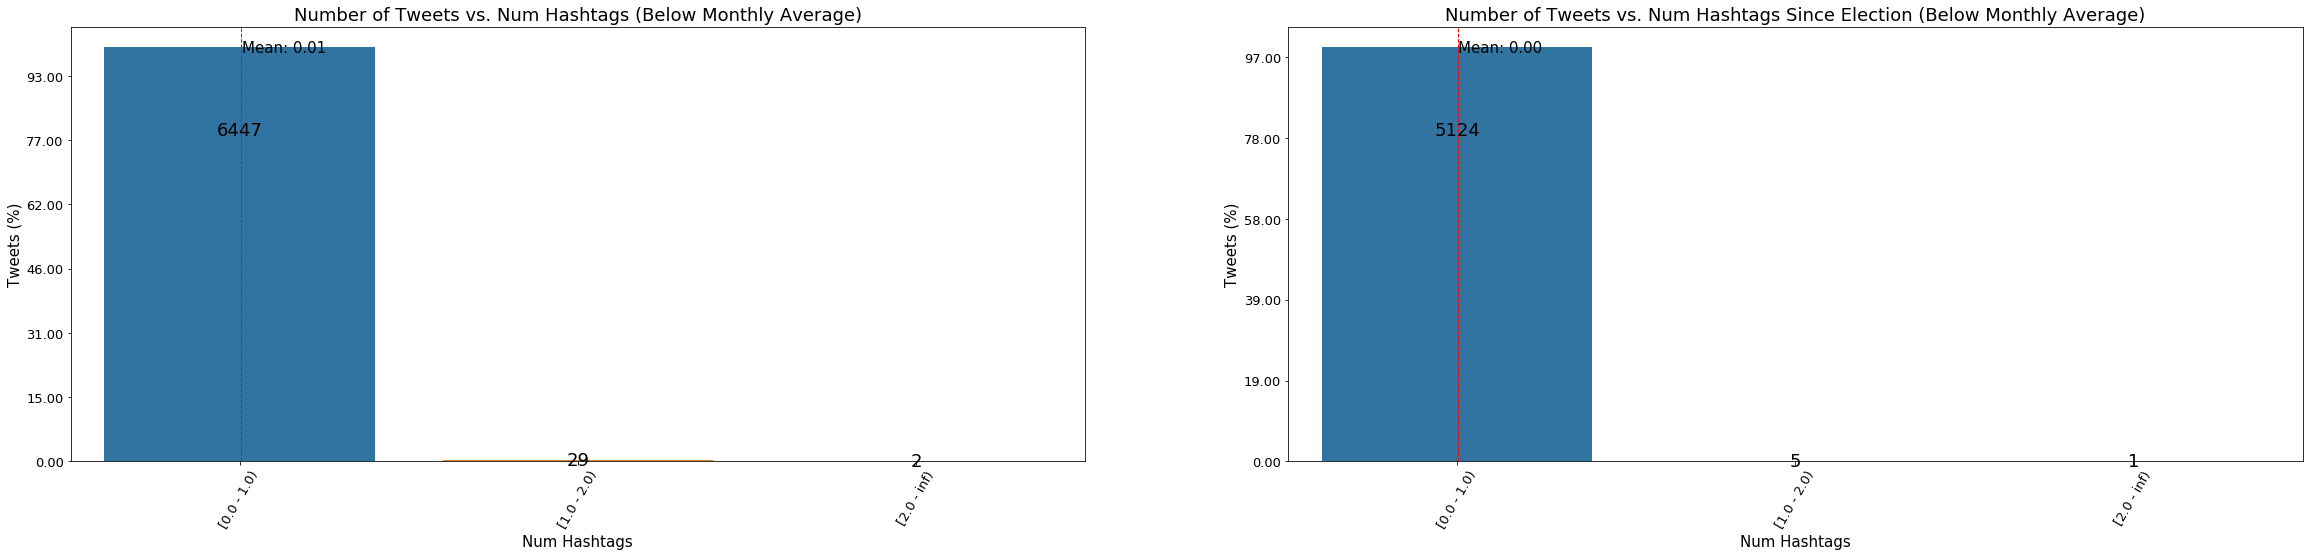

In [62]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_hashtags"], ax, 0, 0, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_hashtags"], ax, 0, 1, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_hashtags"], ax, 0, 0, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_hashtags"], ax, 0, 1, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

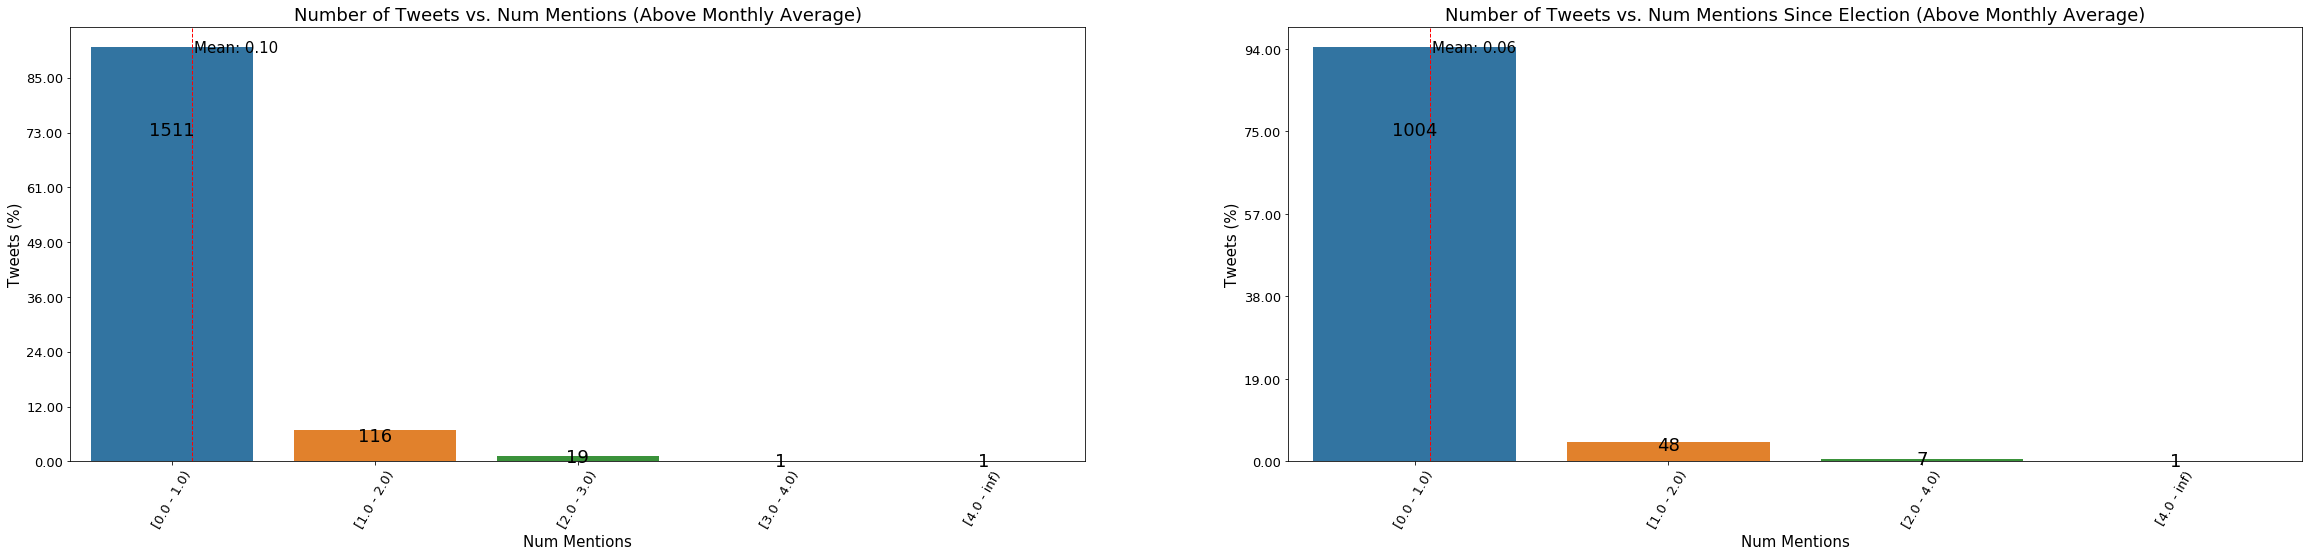

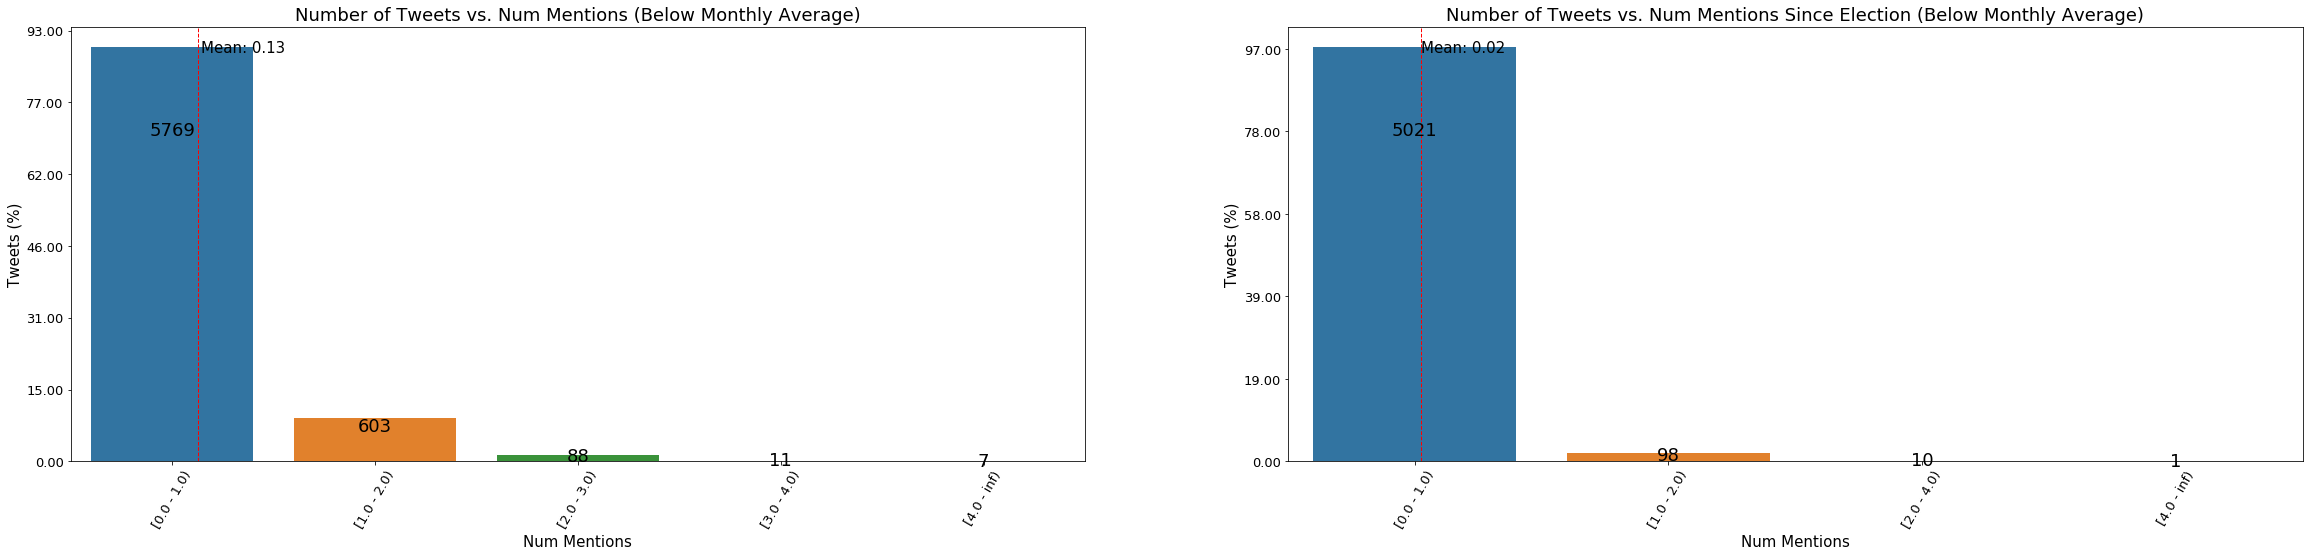

In [63]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_mentions"], ax, 0, 0, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_mentions"], ax, 0, 1, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_mentions"], ax, 0, 0, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_mentions"], ax, 0, 1, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

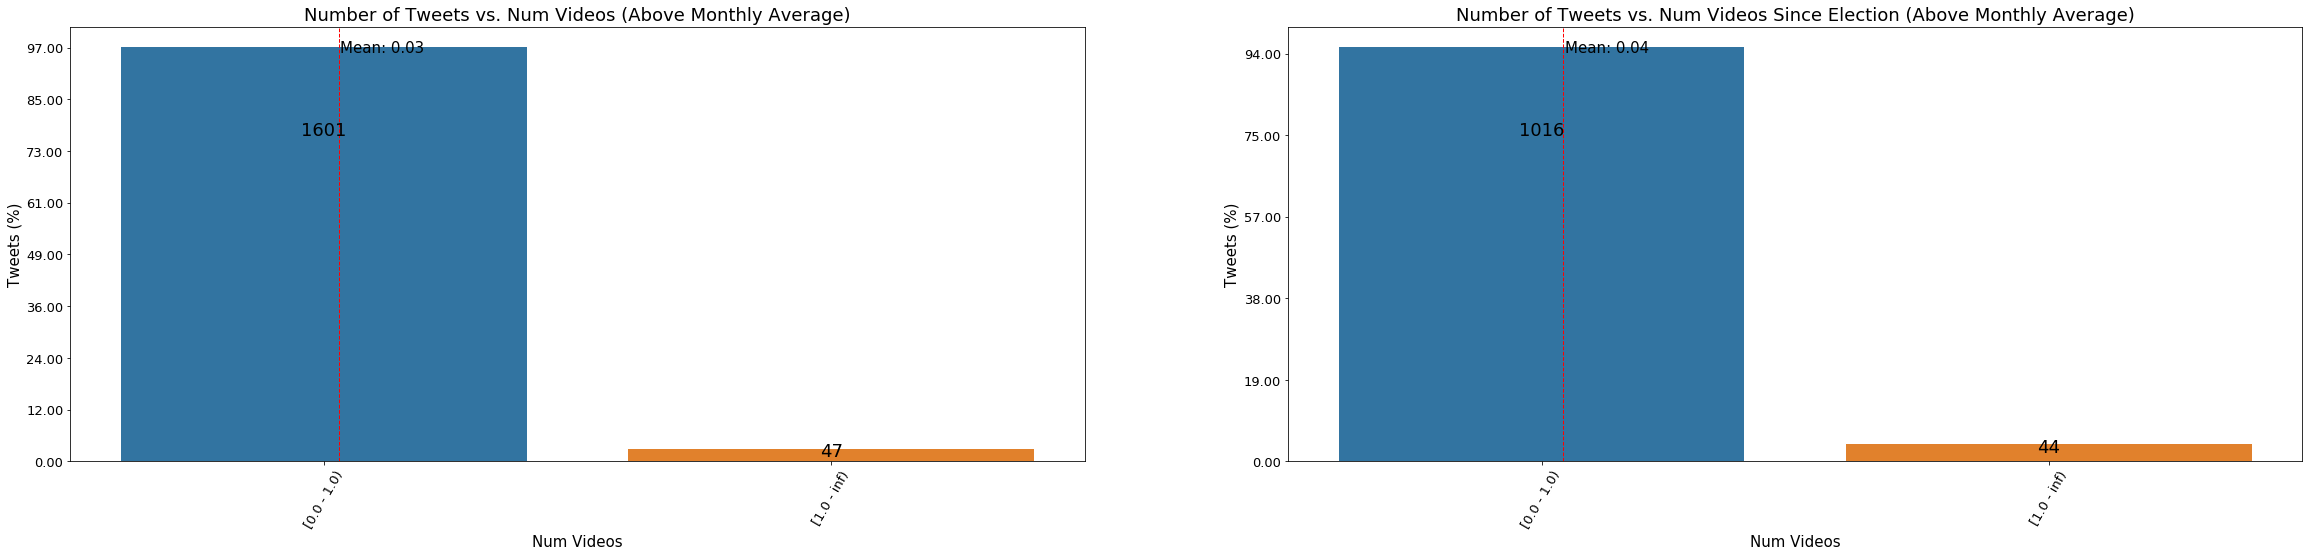

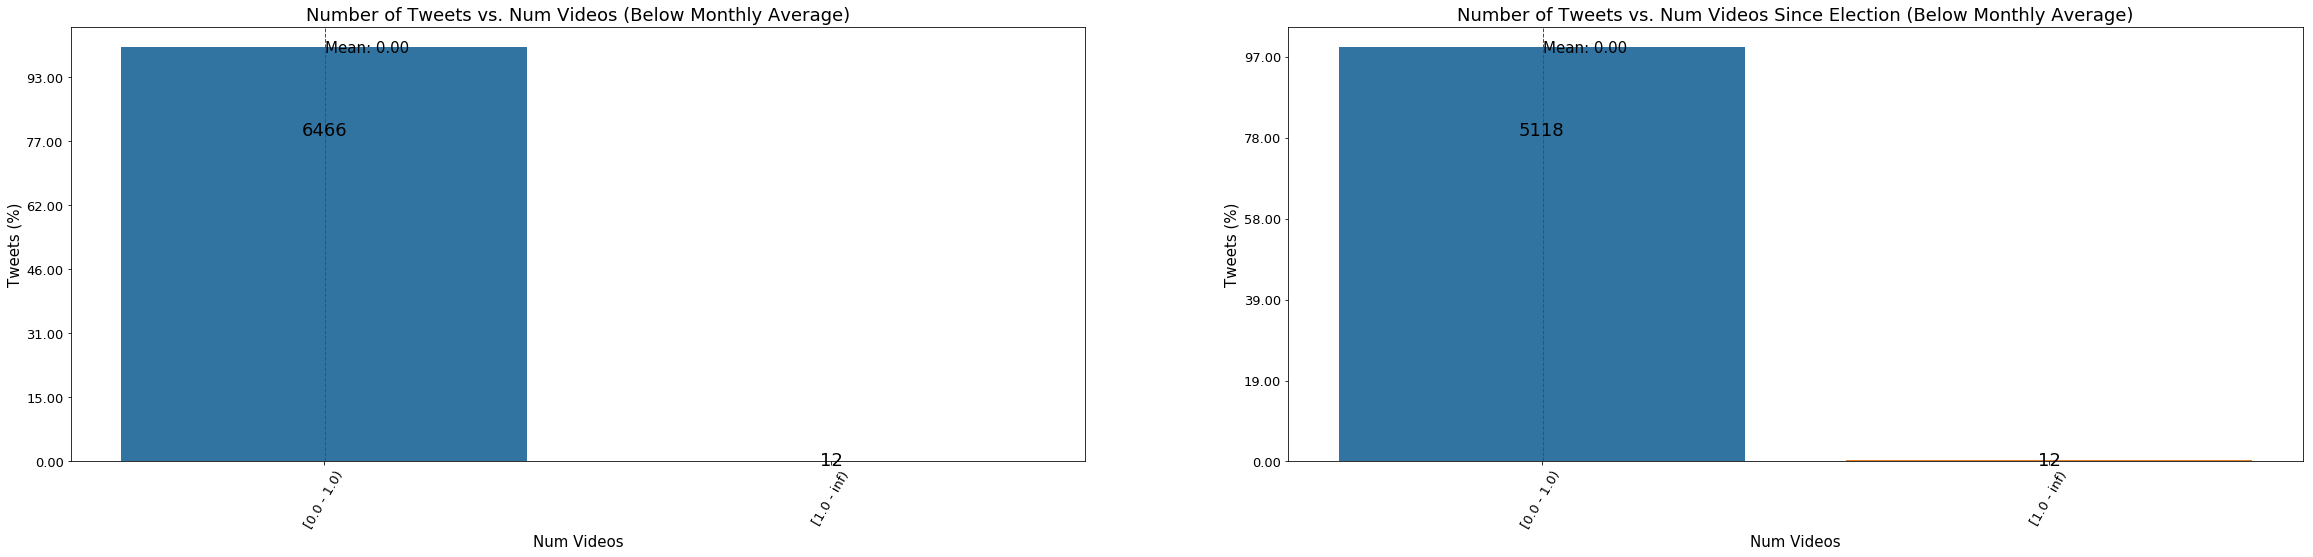

In [69]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_videos"], ax, 0, 0, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_videos"], ax, 0, 1, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_videos"], ax, 0, 0, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_videos"], ax, 0, 1, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

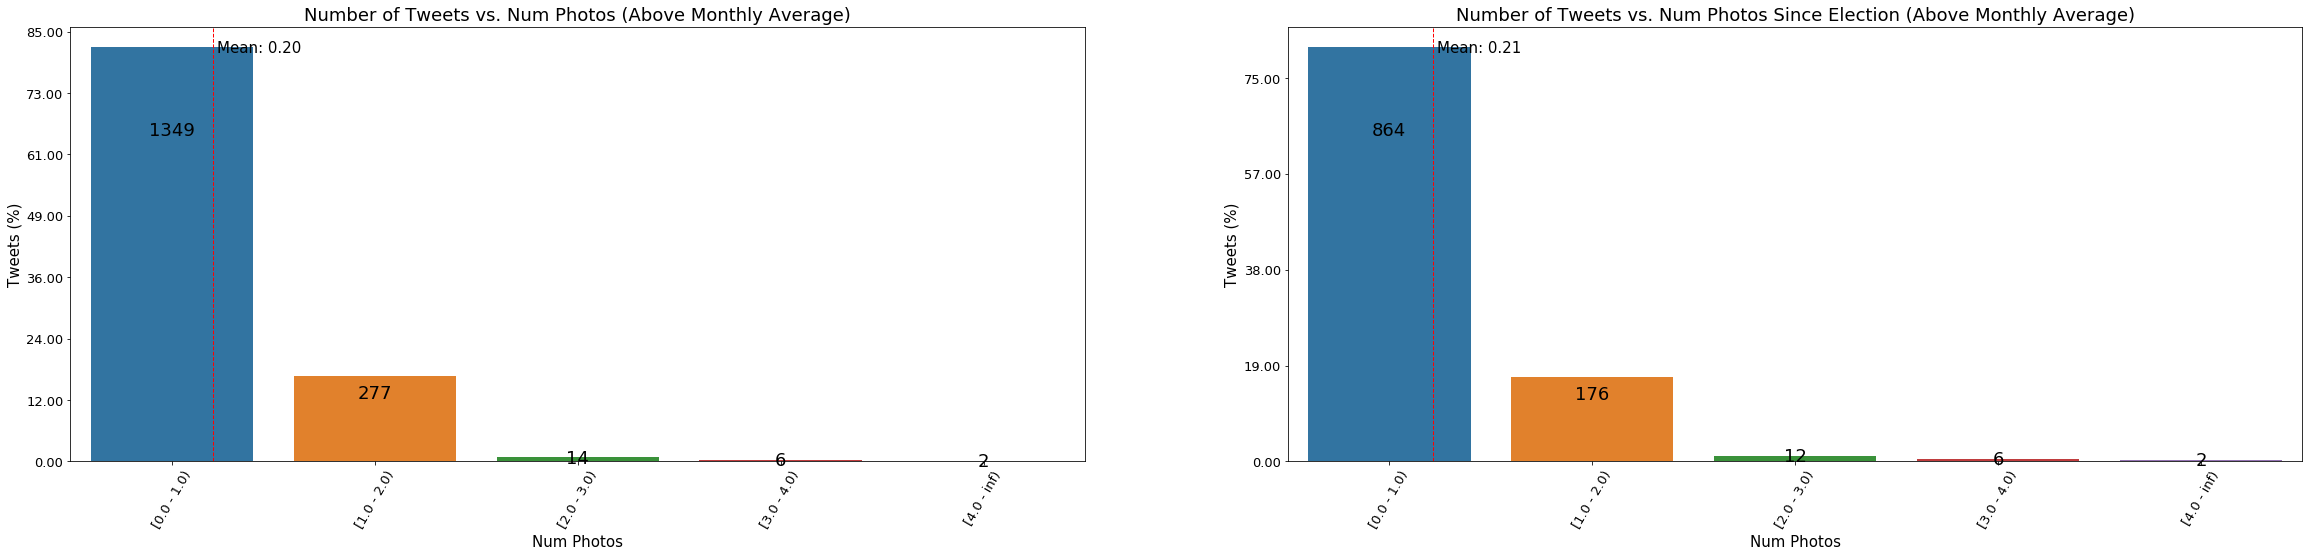

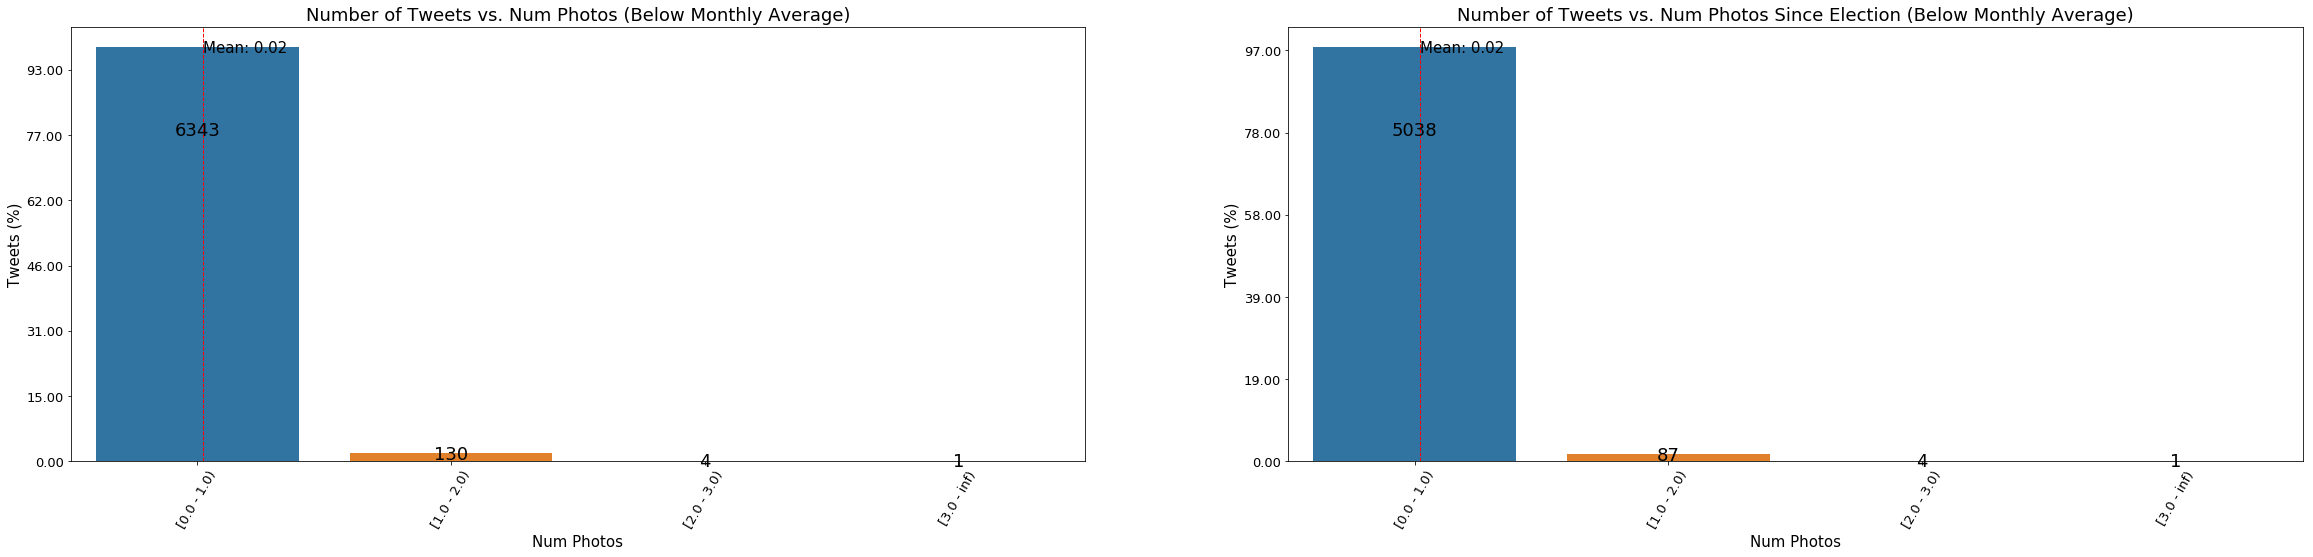

In [70]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_photos"], ax, 0, 0, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_photos"], ax, 0, 1, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_photos"], ax, 0, 0, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_photos"], ax, 0, 1, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [66]:
# stock_tweet.head(10)

In [67]:
# since_election.head(10)

## This is what we will be using for models...

In [68]:
since_election.to_csv('./since_election_with_cluster_{}'.format(file_name), index=False)